In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import seaborn as sns
sns.set_style('white', {'font.family':'sans-serif'})
sns.set_context('paper', font_scale=1.4)
sns.set_palette("cubehelix", 8)

In [3]:
class GaussianMixtureModel:
    def __init__(self, mu, sigma, weights):
        self.weights = np.atleast_1d(weights)
        self.weights /= self.weights.sum()
        self.mu = np.atleast_1d(mu)
        self.sigma = np.atleast_1d(sigma)        
        self.K = len(self.weights)        
        assert self.K == len(self.mu)
        assert self.K == len(self.sigma)
            
    def marginal(self, x):
        '''Marginal likelihood of mixture model'''
        return np.asarray([self.weights[i] * stats.norm.pdf(x, self.mu[i], self.sigma[i]) 
                           for i in range(self.K)]).sum(0)
    
    def sample(self, n, return_z=False):
        z = np.random.choice(self.K, p=self.weights, size=n)
        xz = np.array([stats.norm.rvs(self.mu[i], self.sigma[i], size=n) for i in range(self.K)])
        y = xz[z, range(n)]
        if return_z:
            return y, z
        else:
            return y
        
    def draw(self, xmin=-20, xmax=20, fill=True, color='mediumpurple', label=None, ax=None):
        if ax is None:
            ax = plt.gca()
        x = np.linspace(xmin, xmax, 100)
        if fill:
            ax.fill(x, self.marginal(x), label=label, alpha=0.4, color=color)
        ax.plot(x, self.marginal(x), color=color, label=label)

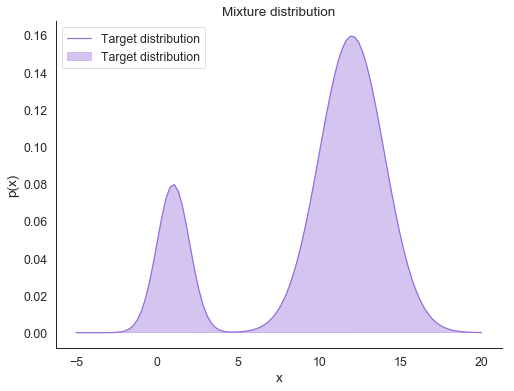

In [4]:
gmm = GaussianMixtureModel(mu=[1.0, 12.0], sigma=[1.0, 2.0], weights=[0.2, 0.8])

fig, ax = plt.subplots(figsize=(8,6))
plt.title('Mixture distribution')
gmm.draw(-5, 20, fill=True, label='Target distribution')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
sns.despine()

In [5]:
def delta(i,j):
    # Vectorized Kronecker delta
    return (np.asarray(i)==np.asarray(j)).astype(np.int32)

In [6]:
def estep(x_h, alpha, mu, sigma2):
    sigma = np.sqrt(sigma2)
    p_xGz = np.array([stats.norm.pdf(x_h, m, s) for (m,s) in zip(mu, sigma)]).T
    p_xz = p_xGz * alpha[None, :] # 10x2
    p_zGx = p_xz / p_xz.sum(-1, keepdims=True)
    return p_zGx # q

In [16]:
def mstep(x_o, z_o, x_h, q, alpha, mu, sigma2):
    
    def n_k(k):
        delta_zk = delta(z_o, k)
        q_k = q[:, k]
        return (delta_zk.sum() + q_k.sum()), delta_zk, q_k
    
       
    def mu_sigma2_k(k):
        nk, delta_zk, q_k = n_k(k)
        m = ((delta_zk*x_o).sum() + (q_k*x_h).sum()) / nk
        s = ((delta_zk*(x_o - mu[k])**2).sum() + (q_k*(x_h - mu[k])**2).sum()) / nk
        return m, s
    
    K = len(alpha)
    nks = np.asarray([n_k(k)[0] for k in range(K)])
    alpha_new = nks / nks.sum()    
    mu_sigma2_new = np.asarray([mu_sigma2_k(k) for k in range(K)])
    
    return alpha_new, mu_sigma2_new[:, 0], mu_sigma2_new[:, 1]

def em(x_o, z_o, x_h, alpha, mu, sigma2, episodes=200, verbose=True):   
    for eps in range(episodes):
        q = estep(x_h, alpha, mu, sigma2)
        alpha, mu, sigma2 = mstep(x_o, z_o, x_h, q, alpha, mu, sigma2)
        if verbose and eps % max((episodes//10),1) == 0:
            print(eps, alpha, mu, np.sqrt(sigma2))
            
    return alpha, mu, sigma2

In [17]:
def init_random(gmm, k):
    alpha = np.ones(k)/k
    mu = np.random.uniform(low=-1, high=20, size=k)
    sigma2 = np.random.uniform(0.1, 2, size=k)
    return alpha, mu, sigma2

def init_flipped(gmm, k):
    alpha = gmm.weights.copy()[::-1][:k]
    mu = gmm.mu.copy()[::-1][:k]
    sigma2 = (gmm.sigma.copy()[::-1]**2)[:k]
    return alpha, mu, sigma2

def init_well(gmm, k):
    alpha = np.ones(k)/k
    mu = gmm.mu.copy()[:k] + np.random.rand(k)
    sigma2 = (gmm.sigma.copy()[:k] + np.random.rand(k)*1e-1)**2

def run_experiment(gmm_target, n=600, n_full=20, k=2, init='random', episodes=50, plot=True):
    x, z = gmm_target.sample(n, return_z=True)
    x_o, z_o = x[:n_full], z[:n_full] # obs
    x_h, z_h = x[n_full:], z[n_full:] # partial obs
    
    theta = {
        'random' : init_random,
        'flipped' : init_flipped, 
        'well' : init_well
    }[init](gmm_target, k)
    
    alpha, mu, sigma2 = em(x_o, z_o, x_h, *theta, episodes=episodes, verbose=plot)    
    gmm_pred = GaussianMixtureModel(mu=mu, sigma=np.sqrt(sigma2), weights=alpha)
    
    z_h_pred = estep(x_h, alpha, mu, sigma2).argmax(1)
    normalized_error = abs(z_h - z_h_pred).sum().astype(float) / len(z_h)
    
    if plot:
        fig, ax = plt.subplots(figsize=(8,6))
        plt.title('Result')
        gmm.draw(-5, 20, fill=True, label='Target distribution', ax=ax)
        gmm_pred.draw(-5, 20, fill=False, label='EM Result', color='black', ax=ax)
        ax.scatter(x_h, np.zeros(len(x_h)), marker = '+', label='Partially observed samples')
        ax.scatter(x_o, np.zeros(len(x_o)), label='Fully observed samples', color='red')
        plt.ylabel('p(x)')
        plt.xlabel('x')
        plt.legend()
        sns.despine()
        plt.show()
        
    return normalized_error

def run_experiments(gmm, nexp, **run_experiment_kwargs):
    errs = np.array([run_experiment(gmm, plot=False, **run_experiment_kwargs) for _ in range(nexp)])
    return errs    

Run experiments. Here we use `random` initialization.

0 [0.25181727 0.74818273] [ 1.62517539 12.25358109] [5.42564749 2.37489294]
1 [0.25097903 0.74902097] [ 1.7967535  12.18419503] [3.08354113 1.91664381]
2 [0.23454847 0.76545153] [ 1.12464724 12.16717239] [1.8721025  1.91351648]
3 [0.22619952 0.77380048] [ 0.85720555 12.12620792] [1.08689798 1.94701982]
4 [0.22599823 0.77400177] [ 0.85120451 12.12502957] [1.03448444 1.9477232 ]


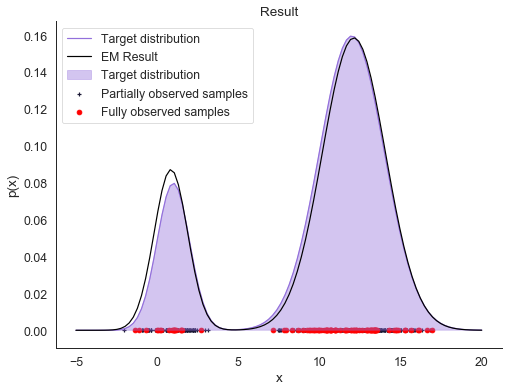

Prediction error 0.0


In [38]:
err = run_experiment(gmm, init='random', episodes=5, n=500, n_full=100);
print('Prediction error', err)

How does the prediction error change as we increase the fully observed variables

In [39]:
nerr = run_experiments(gmm, 100, init='flipped', episodes=50, n=60, n_full=5).astype(float)
nerr.mean(), nerr.std() # average, std of normalized prediction error

(0.8156363636363636, 0.3171778446297392)

In [40]:
nerr = run_experiments(gmm, 100, init='flipped', episodes=50, n=60, n_full=20).astype(float)
nerr.mean(), nerr.std() # average, std of normalized prediction error

(0.00025, 0.002487468592766549)

How does the prediction error change as we increase the fully observed variables (random-init) case

In [41]:
nerr = run_experiments(gmm, 100, init='random', episodes=50, n=60, n_full=5).astype(float)
nerr.mean(), nerr.std() # average, std of normalized prediction error

(0.30527272727272725, 0.43864023549869097)

In [42]:
nerr = run_experiments(gmm, 100, init='random', episodes=50, n=60, n_full=20).astype(float)
nerr.mean(), nerr.std() # average, std of normalized prediction error

(0.002, 0.017564168070250297)